# ロジスティック回帰

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


class ScratchLogisticRegression:#呼び出しでは引数に(n_iteration=100,alfa = 0.05)が入っているが元にはかかなくていいのか
    """
    ロジスティック回帰のスクラッチ実装
    
    Parameters
    ----------
    n_iteration : int
      イテレーション数
    alfa : float 学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue
      
    Attributes
    ----------
    self.theta : 次の形のndarray, shape (n_features,)
      パラメータ
    self.theta_list
    self.loss : 次の形のndarray, shape (self.n_iteration)
      訓練データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.n_iteration)
      検証データに対する損失の記録
    """
    
    
    def __init__(self, n_iteration, alfa,lam):
        self.n_iteration = n_iteration # イテレーター最急降下を繰り返す回数
        self.alfa = alfa  #学習率
        self.lam = lam 
        #self.bias = bias# バイアス項を入れるかどうか、メソッド呼び出しで定義する
        #self.verbose = verbose# 学習過程を出力するかどうか、メソッド呼び出しで定義する
        self.theta = np.array(None) #線形回帰のパラメータベクトル
        self.y_hat = np.array(None) #線形回帰のパラメータベクトル
        self.y_val_hat = np.array([]) #線形回帰のパラメータベクトル
        self.theta_list = np.array(None)
        self.y_hat_linear = 0
        # 目的関数の値を記録する配列を用意
        self.loss = np.array([])#訓練データに対する損失の記録 次の形のndarray, shape (self.n_iteration)
        self.val_loss = np.array([])#検証データに対する損失の記録 次の形のndarray, shape (self.n_iteration)
      

    def fit(self, X, y, X_val=None, y_val=None):
        
        #------Xにバイアス項を追加する------

        #データ数の１の配列
        bias1 = np.repeat(1,len(X))

        #目的変数のデータフレームにバイアス項を追加
        X = np.insert(X, 0, bias1, axis=1)

        #print("X.size:{}".format(X.size)) #------検証中--------
        #print("type(X):{}".format(type(X))) #------検証中--------
        #print("X.shape:{}".format(X.shape)) #------検証中--------
        #print("X:{}".format(X)) #------検証中--------

        #------X_valにバイアス項を追加する------

        #データ数の１の配列
        bias1 = np.repeat(1,len(X_val))

        #目的変数のデータフレームにバイアス項を追加
        X_val = np.insert(X_val, 0, bias1, axis=1)

        #         print("X_val.size:{}".format(X_val.size)) #------検証中--------
        #         print("type(X_val):{}".format(type(X_val))) #------検証中--------
        #         print("X_val.shape:{}".format(X_val.shape)) #------検証中--------
        #         print("X_val:{}".format(X_val)) #------検証中--------
        
        
        
        
        #self.θをXのデータ数と同じゼロが入ったndarrayとする（109行目付近でlen(self.theta)を使う為）
        self.theta = np.zeros(X.shape[1])
        #print(X)
        
        for i in range(self.n_iteration):
            #print("イテレーション回数i:{}".format(i)) #------デバック--------
            
            # ①仮定関数呼び出し
            self.y_hat = self._Logistic_hypothesis(X)

            # ②パラメータthetaの算出　最急降下法によるパラメータthetaの更新値計算
            self.theta = self._gradient_descent(X,y,self.y_hat)
            #print(self.theta)
            #print("②self.theta:{}".format(self.theta)) #------検証中--------
            
            # ③　②の新パラメータthetaを使いXのself.y_hatを計算
            self.y_hat = self._Logistic_hypothesis(X)
#             self.y_hat = self.predict(X)
#             print("i:{}".format(i)) #------検証中--------
            
            
            
            #print("③新theta代入後のself.y_hat{}".format(self.y_hat)) #------検証中--------
            
            #-------------------------

            # ④ XとX_valの目的関数値を出力し、ndarrayに格納
                        
            #　Xの目的関数の値をself.loss_funcを出力
            self.loss_func = self.Loss_function(X,self.y_hat, y)
            #print("④Xの損失関数self.loss_func:{}".format(self.loss_func)) #------検証中--------
            
            #Xの損失関数をndarrayに格納
            self.loss = np.append(self.loss , self.loss_func)
            
            #-------------------------
            
            #X_valの目的関数の値をself.y_val_hatとして出力
            self.y_val_hat = self._Logistic_hypothesis(X_val)
#             self.y_val_hat = self.predict(X_val) #self._linear_hypothesis()の値を受け取る
            
            #次に上で出したself.y_val_hatを使ってX_testの損失関数を出力する
            self.val_loss_func = self.Loss_function(X_val,self.y_val_hat, y_val)
            #print("④X_valの損失関数self.loss_func:{}".format(self.val_loss_func)) #------検証中--------
            
            #X_valの損失関数を専用のndarrayであるself.val_lossに格納
            self.val_loss = np.append(self.val_loss,self.val_loss_func)
        
        
            
    
    # ①仮定関数作成
    def _Logistic_hypothesis(self,X):
    
        """
        線形の仮定関数を計算する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データ
          
        self.theta: パラメータベクトル
        
        X_j : j番目の特徴量
        theta_j: j番目のパラメータ（重み）
        
        Returns
        -------
        self.y_hat：目的変数の予測値（次の形のndarray, shape (n_samples, 1)ロジスティック回帰の仮定関数から算出）
        
        """
                
        #1次元配列は転置できないのでreshapeで２次元に変えてから転置する
        theta_2dim = self.theta.reshape(( 1, len(self.theta)))
        #print(theta_2dim.transpose())
        
        
        
        #n個の特徴量の仮定関数hθにおける特徴量をXjとし一般式としたもの
#         print("X.shape①仮定関数作成:{}".format(X.shape)) #------検証中--------
#         print("theta_2dim.shape①仮定関数作成:{}".format(theta_2dim.shape)) #------検証中--------

        
        self.y_hat_linear = X @ theta_2dim.transpose()  #ロジスティック回帰の仮定関数
                        
        #----ロジスティック回帰の仮定関数----
        self.y_hat = 1 / (1 + (math.e)** -(self.y_hat_linear))#ダイバー記載の公式 math.e=2.718281828459045
        
        #print("①のself.y_hat:{}".format(self.y_hat)) #------検証中--------
        return self.y_hat
        
                     
    #②self.thetaの最急降下を１回行う          
    def _gradient_descent(self,X,y,y_hat):
        """
        最急降下を１回行ったself.thetaを計算する
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)訓練データ
        self.theta: パラメータベクトル
        self.y_hat
        self.alfa: 学習率
        self.lam: 正則化パラメータ
        
        Returns
        -------
        self.theta：最急降下を１回行ったパラメータ
        
        """
                
        #データの数（行の数）
        m = len(X[:,0])
        #print("m:{}".format(self.m)) #------検証中--------
        
        #特徴量の数（列の数）
        n = len(X[0,:])
        #print("n:{}".format(n)) #------検証中--------
        #----パラメータself.thetaを再急降下法で最適化する一般式----

        #error(予測値と真の値の差分）のデータ数iの値を１～ｍまで（データ数ある分だけ）合計し、θの一般式self.θ[j] を出して、それを特徴量の数ｎ個分をfor文で作り出す
        for j in range(n): # n:特徴量の数（列の数） 
            
            #error(予測値と真の値の差分）にX[i,j]を掛けた値をｍ（データ数の数）個分足すので、足した変数をsum_errorとする
            sum_error = 0 #とりあえず定義（初期値）for文の為。値はゼロ
            
            #ここはerrorをｍ個作ってそれをsum_errorに足していく
            

            #             print(type(self.y_hat))
            #             print(type(y))
            
            
            
            for i in range( m ): 
                
                #error(予測値と真の値の差分）
                error =self.y_hat[i] - y[i]
                
                #sum_errorはデータ数（ｍ）分　error * X[i,j]を繰り返し足し続けた合計値
                sum_error += error * X[i,j] #Σi=0~m　((hθ_Xj) - yi)を全部足した
                
            #最急降下法により次のthetaを求める一般式。ここでθを0からｎ個作っていく
            self.theta[j] = self.theta[j] - self.alfa * ((1 / m)  * sum_error + ((self.lam / m ) * self.theta[j]) )
            self.theta_list = np.append(self.theta_list ,self.theta[j])
#             print("self.theta_list:{}".format(self.theta_list)) #------検証中--------

            
        return self.theta
    
    # ③ロジスティック回帰を使いテストデータの目的変数を推定する
    def predict(self, X):
            
        """
        thetaとXをロジスティック回帰仮定関数に代入し、Xに対しｙの推定値を出力
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)

        Returns
        -------
        self.y_hat : 次の形のndarray, shape (n_samples, 1)
        線形回帰による推定結果

        """
        #データ数の１の配列
        bias1 = np.repeat(1,len(X))

        #目的変数のデータフレームにバイアス項を追加
        X = np.insert(X, 0, bias1, axis=1)
        print("X[:,0]:{}".format(X[:,0])) #------検証中--------
        print("X[:,1]:{}".format(X[:,1])) #------検証中--------

#         if X[:,0] == X[:,1]:
#             np.delete(X, 0, 1)
#         else:
#             pass
        
                
        #1次元配列は転置できないのでreshapeで２次元に変えてから転置する
        theta_2dim = self.theta.reshape(( 1, len(self.theta)))
#         print("self.theta:{}".format(self.theta)) #------検証中--------
                
        #n個の特徴量の仮定関数hθにおける特徴量をXjとし一般式としたもの
#         print("X.shape:{}".format(X.shape)) #------検証中--------
#         print("theta_2dim.shape:{}".format(theta_2dim.shape)) #------検証中--------
#         print("theta_2dim:{}".format(theta_2dim)) #------検証中--------
        #ロジスティック回帰の仮定関数の行列積部分
#         print("X.size:{}".format(X.size)) #------検証中--------
#         print("type(X):{}".format(type(X))) #------検証中--------
#         print("X.shape:{}".format(X.shape)) #------検証中--------
        #print("X:{}".format(X)) #------検証中--------
#         print("theta_2dim.transpose() .size:{}".format(theta_2dim.transpose() .size)) #------検証中--------
#         print("type(theta_2dim.transpose() ):{}".format(type(theta_2dim.transpose() ))) #------検証中--------
#         print("theta_2dim.transpose() .shape:{}".format(theta_2dim.transpose() .shape)) #------検証中--------
#         print("theta_2dim.transpose() :{}".format(theta_2dim.transpose() )) #------検証中--------
#         print("------検証中---------") 
        
        print("X.shape③目的変数:{}".format(X.shape)) #------検証中--------
        print("theta_2dim.shape③目的変数:{}".format(theta_2dim.shape)) #------検証中--------
        print("X:{}".format(X)) #------検証中--------

    
        self.y_hat_linear = X @ theta_2dim.transpose()  
        
                        
        #----ロジスティック回帰の仮定関数----
        self.y_hat = 1 / (1 + (math.e)** -(self.y_hat_linear))#ダイバー記載の公式 math.e=2.718281828459045
        
        
        return self.y_hat
    
#     #self.y_hatを1と0のラベルとしたもの
#     def predict_proba(self, X):
        
        
        
        
    # ④目的関数（損失関数）
    def Loss_function(self,X,y_pred, y):
        """
        目的関数
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        y_pred : self.y_hatの値、テストデータの目的変数　ndarray, shape (n_samples)
        y : 実データの目的変数　ndarray, shape (n_samples)
        self.theta : パラメータベクトル, shape (n_samples)
        self.self.lam : 正則化パラメータ

        Returns
        -------
        self.loss_func : 目的関数
        self.loss : 訓練用データの目的関数の値がイテレーション回数格納されるndarray
        self.val_loss : 検証用データの目的関数の値がイテレーション回数格納されるndarray
        """
        
#       #データの数（行の数）
        m = len(y_pred)
#         #         print("m:{}".format(m))
#         #         print("type(m):{}".format(type(m)))
#         #         print("y_pred:{}".format(y_pred))
#         #         print("y:{}".format(y))
        
#       #特徴量の数（列の数）
        n = len(X[0,:])
#       print("n:{}".format(n)) #------検証中--------
        

        #目的関数のΣi部分を計算
        sum_part_i = 0
        
        for i in range(m):
            #print("④目的関数self.m:{}.i:{} ,y_pred[i]:{} , y[i]:{}".format(m,i,y_pred[i],y[i]))# ------検証中--------
            
            part_i = (-y[i] * math.log(y_pred[i], math.e) - (1 - y[i]) * math.log((1-y_pred[i]), math.e))
            sum_part_i += part_i
        #print("④目的関数 sum_part_i:{}".format(sum_part_i))# ------検証中--------

            
        #目的関数のΣj部分を計算
        sum_part_j = 0
        for j in range(n):
            part_j = (self.lam / (2 * m) * (self.theta[j]**2))
            sum_part_j += part_i
        #print("④目的関数 sum_part_j:{}".format(sum_part_j))# ------検証中--------
        
        self.loss_func = sum_part_i + sum_part_j

        #損失関数を出力する
        return self.loss_func
    
    
    #⑤確率を出力するpredict_proba（predictメソッドのリターンself.y_hatを0.1に変換）
    def _predict_proba(self):
        """
        ロジスティック回帰を使い確率を推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """
        
        #
        self.y_hat = np.where(self.y_hat < 0.5, 0, 1)
        return self.y_hat
    
    
    #【グラフ描画】トレーニングデータとテストデータの損失関数　横軸にイテレーション回数縦軸に損失関数
    def Learnig_curve(self):

        #self.lossの要素数をndarrayにした。散布図のX座標で使う為
        num = np.arange(len(self.loss))
        num_val = np.arange(len(self.val_loss))
        
        #print("num:{}".format(num))
        #print("self.loss:{}".format(self.loss))
        #print("num_val:{}".format(num))
        #print("self.val_loss:{}".format(self.val_loss))

        #散布図の描画
        plt.scatter(num, self.loss,color = "red" )
        plt.scatter(num_val, self.val_loss, color = "blue")
        plt.colorbar()
        plt.grid()
        return plt.show()
    
    
    
    
    


In [2]:
# # theta = [-2.86590910e-04  8.08181510e-01 -7.85813603e-01]
# bbb = np.array([[3] [4] [5]])

# print("X.size:{}".format(X.size)) #------検証中--------
# # print("type(X):{}".format(type(X))) #------検証中--------
# # print("X.shape:{}".format(X.shape)) #------検証中--------
# # print("X:{}".format(X)) #------検証中--------

# # print("theta_2dim.transpose() .size:{}".format(theta_2dim.transpose() .size)) #------検証中--------
# # print("type(theta_2dim.transpose() ):{}".format(type(theta_2dim.transpose() ))) #------検証中--------
# # print("theta_2dim.transpose() .shape:{}".format(theta_2dim.transpose() .shape)) #------検証中--------
# # print("theta_2dim.transpose() :{}".format(theta_2dim.transpose() )) #------検証中--------
        

# aaa = X @ bbb
# print(aaa)

### 【問題５】学習と推定

In [3]:
# #----インポート----
# import numpy as np
# import pandas as pd
# import matplotlib
# import matplotlib.pyplot as plt
# %matplotlib inline
# import warnings
# warnings.filterwarnings('ignore')
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# from sklearn.svm import LinearSVC
# from sklearn.preprocessing import StandardScaler#標準化のライブラリ

# #アヤメインスタンスを生成
# heacet = load_iris()

# heacet = pd.DataFrame(heacet)#, columns=["カラム名１","カラム名２","カラム名３","カラム名４"]


# # #yに関しては"Species == [0, 1]"だけのデータを表示させる。（ロジスティック回帰は判定を0.1とする為、目的変数も0.1に変換しないといけない）
# # heacet = heacet.query("Species == [0, 1]")


# heacet = df.query("Species == [0, 1]").loc[:, ["sepal_length", "petal_length", "Species"]]
# heacet.head()



# # #DataFrame型変数（X,y）に格納
# X = pd.DataFrame(heacet.data, columns=["sepal_length","sepal_width","petal_length","petal_width"])


# y = (pd.DataFrame(heacet.target, columns=["Species"]))


# print(X)
# print(y)
# #setosa:0・virgicolor:1・virginica:2・sepal_length・petal_length


In [4]:
#----インポート----
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler#標準化のライブラリ



# アイリスデータを抽出
iris_dataset = load_iris()
# .data 部分を抽出し、カラム名も指定する。
X = pd.DataFrame(iris_dataset.data, columns=["sepal_length", "sepal_width", "petal_length", "petal_width"]).loc[ :  ,  ["sepal_length", "sepal_width" ] ]

# .target 部分を抽出し、カラム名も指定する。
y = pd.DataFrame(iris_dataset.target, columns=["Species"])
# .concatを使用してXとyを列方向で結合する。
df = pd.concat([X, y], axis=1)

# .queryで行抽出、locで列抽出する。
df_selected = df.query("Species == [0, 1]")

# 二度手間だが再度特徴量と目的変数に分けた
X = df_selected.iloc[:, :-1]
y = df_selected.loc[:, "Species"]

print(X)
print(y)

    sepal_length  sepal_width
0            5.1          3.5
1            4.9          3.0
2            4.7          3.2
3            4.6          3.1
4            5.0          3.6
..           ...          ...
95           5.7          3.0
96           5.7          2.9
97           6.2          2.9
98           5.1          2.5
99           5.7          2.8

[100 rows x 2 columns]
0     0
1     0
2     0
3     0
4     0
     ..
95    1
96    1
97    1
98    1
99    1
Name: Species, Length: 100, dtype: int32


In [5]:
#-------------４つの特徴量を標準化する-----------


#データフレームのコピーを作成
scaled_features = X.copy()

#scalerインスタンスを作成し、StandardScalerクラスのfitメソッドに.valuesでndarrayにしたscaled_featuresを代入
scaler = StandardScaler().fit(scaled_features.values) 

#scalerインスタンスのtransformメソッドにscaled_features.valuesを代入し標準化を実行
features = scaler.transform(scaled_features.values) 


#train_test_split訓練データと検証データに分割
X_train, X_test, y_train, y_test = train_test_split(features,y.values , test_size=0.2, random_state=0, shuffle=True
)

# print("X_train:{}".format(X_train))
# print(" X_test:{}".format(X_test))
# print("y_train:{}".format(y_train))
# print("y_test:{}".format(y_test))

# print("X_train:{}".format(type(X_train)))
# print("X_test:{}".format(type(X_test)))
# print("y_train:{}".format(type(y_train)))
# print("y_test:{}".format(type(y_test)))

# print("X_train.shape:{}".format(type(X_train.shape)))
# print("X_test.shape:{}".format(type(X_test.shape)))
# print("y_train.shape:{}".format(type(y_train.shape)))
# print("y_test.shape:{}".format(type(y_test.shape)))



X[:,0]:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
X[:,1]:[-0.73768744  1.92487869 -1.20755205  0.35866332  1.76825716 -0.73768744
 -0.11120129  0.98514947  1.61163562  0.35866332  0.04542025  0.51528486
  0.82852793 -1.8340382  -0.73768744 -1.05093052 -1.36417359 -1.05093052
  0.04542025 -1.67741667]
X.shape③目的変数:(20, 3)
theta_2dim.shape③目的変数:(1, 3)
X:[[ 1.00000000e+00 -7.37687441e-01  6.31902691e-01]
 [ 1.00000000e+00  1.92487869e+00  2.09934449e-03]
 [ 1.00000000e+00 -1.20755205e+00  2.12033793e-01]
 [ 1.00000000e+00  3.58663321e-01 -6.27704002e-01]
 [ 1.00000000e+00  1.76825716e+00 -2.07835104e-01]
 [ 1.00000000e+00 -7.37687441e-01 -1.67737625e+00]
 [ 1.00000000e+00 -1.11201292e-01  1.68157493e+00]
 [ 1.00000000e+00  9.85149470e-01 -6.27704002e-01]
 [ 1.00000000e+00  1.61163562e+00 -6.27704002e-01]
 [ 1.00000000e+00  3.58663321e-01 -2.07835104e-01]
 [ 1.00000000e+00  4.54202458e-02 -1.67737625e+00]
 [ 1.00000000e+00  5.15284858e-01 -1.04757290e+00]
 [ 1.00000000e+

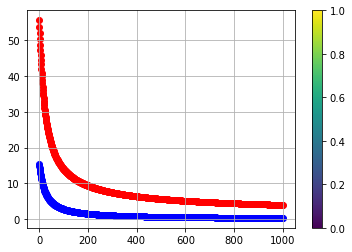

In [6]:
#-------------【訓練用トレーニングデータの代入】スクラッチ実装の学習-----------




#iris_dataという名前でコンペティションクラスを定義
iris_data = ScratchLogisticRegression(n_iteration=1000,alfa = 0.1,lam = 0.1)#なんで学習率は線形回帰はαで、ロジスティック回帰はlrなの？

#iris_dataクラスのfitメソッドで訓練用データを学習。パラメータθを算出
iris_data.fit(X_train,y_train,X_test, y_test)

#iris_dataクラスのpredictで検証用データの予測値y_val_hatを呼び出し
y_val_hat = iris_data.predict(X_test)

# print("y_val_hat:{}".format(y_val_hat)) #------検証中--------
# print("y_test:{}".format(y_test.shape)) #------検証中--------

#iris_dataクラスの_predict_probaで検証用データの予測値y_val_hatの0.1データを呼び出し
hoge = (iris_data._predict_proba()).reshape(y_test.shape[0],)# reshapeでy_testと同じ形に揃えた
print("hoge:{}".format(hoge)) #------検証中--------

#学習曲線を描く関数を呼び出し
iris_data.Learnig_curve()



In [7]:
# 学習結果の成績を行う関数
#iris_dataクラスの_predict_probaで検証用データの予測値y_val_hatの0.1データを呼び出し
hoge = (iris_data._predict_proba()).reshape(y_test.shape[0],)# reshapeでy_testと同じ形に揃えた
def evaluate(y_pred, y_test):
    """
    y_val_hat, y_testの評価指標を計算する
    """
    acc = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    confusion = metrics.confusion_matrix(y_test, y_pred)
    return acc, precision, recall, f1, confusion

print(y_val_hat)
print(y_test)

acc, precision, recall, f1, confusion = evaluate(hoge, y_test)

print("acc : {}\nprecision : {}\nrecall : {}\nf1 : {}\nconfusion matrix \n {}".format(*evaluate(y_test, y_test)))


[[1.43637999e-02]
 [9.99418878e-01]
 [8.72823892e-03]
 [9.71064498e-01]
 [9.99440113e-01]
 [9.27093154e-01]
 [6.73857581e-03]
 [9.97060832e-01]
 [9.99708461e-01]
 [9.07387991e-01]
 [9.95655859e-01]
 [9.95144792e-01]
 [9.90365834e-01]
 [2.97475490e-03]
 [1.43637999e-02]
 [2.82364576e-02]
 [4.20725086e-04]
 [4.56274808e-03]
 [1.90462567e-03]
 [9.75002195e-03]]
[0 1 0 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0]
acc : 1.0
precision : 1.0
recall : 1.0
f1 : 1.0
confusion matrix 
 [[10  0]
 [ 0 10]]


In [8]:
# 決定領域の可視化を行う関数
def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。

    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2

    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    print("mesh.shape:{}".format(mesh.shape)) #------検証中--------
    y_pred = model.predict(mesh).reshape(mesh_f0.shape)

    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()
    
    
    
    

### 【問題7】決定領域の可視化

mesh.shape:(237524, 2)
X[:,0]:[1. 1. 1. ... 1. 1. 1.]
X[:,1]:[-2.3340382 -2.3240382 -2.3140382 ...  2.3959618  2.4059618  2.4159618]
X.shape③目的変数:(237524, 3)
theta_2dim.shape③目的変数:(1, 3)
X:[[ 1.         -2.3340382  -2.17737625]
 [ 1.         -2.3240382  -2.17737625]
 [ 1.         -2.3140382  -2.17737625]
 ...
 [ 1.          2.3959618   2.80262375]
 [ 1.          2.4059618   2.80262375]
 [ 1.          2.4159618   2.80262375]]


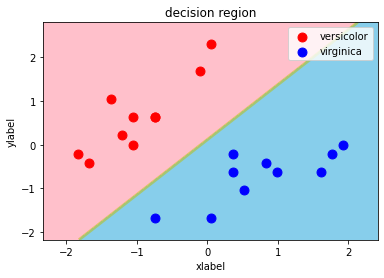

In [9]:

# X = df.query("Species == [0, 1]").loc[:, ["sepal_length", "sepal_width"]]
# X = X.values
# y = (df.query("Species == [0, 1]")["Species"]).values


# print(X_test.shape)
# print(y_test.shape)
# print(type(X_test))
# print(type(y_test))
# print(X_test)
# print(y_test)

#決定領域の可視化関数呼び出し
decision_region(X_test,y_test,iris_data, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica'])

ハマったポイント

・バイアス化を最初クラスの外に書いたらひな型の領域を描く関数が機能せず、中に書いたらfitとpredictの両方の関数にバイアス化する
コードが必要でそれに気づかず時間がかかった。クラスの中のメソッド同士でもクラスの外でメソッドを呼び出す場合fitのXなどの変数をpredictで使うことはできない。

・クラスの中のメソッドをクラス内とクラス外の両方で使うとき、同じメソッドを２つ作る。クラス外から呼び出すときはクラス内の変数が使えない為
フィットメソッドにバイアス追加を付けて
